In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import esig.tosig as ts
import sklearn
import xgboost

In [2]:
import warnings
warnings.filterwarnings('ignore')


# Data and data processing

In [2]:
#data daily
timeseriesY=pd.read_excel(r"C:\Users\Colomban Basset\Documents\These Bitcoin\4.Forecast\Court-Moyen terme\Data Daily BTC\Data Daily 12AM.xlsx")
BTC_price=timeseriesY[['Date_format_ok_2','Close','Open','Return_log']]
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date_format_ok_2'])
BTC_price.set_index('Date', inplace=True)
BTC_price.head()

,Date_format_ok_2,Close,Open,Return_log
Date,,,,
2017-07-02,2017-07-02 00:00:00,2358.00,2392.95,NaN
2017-07-03,2017-07-03 00:00:00,2494.03,2505.57,0.045989
2017-07-04,2017-07-04 00:00:00,2571.15,2546.73,0.016294
2017-07-05,2017-07-05 00:00:00,2566.81,2599.07,0.020344
2017-07-06,2017-07-06 00:00:00,2605.00,2611.39,0.004729


In [4]:
#data hourly 
timeseriesY=pd.read_excel(r"C:\Users\Colomban Basset\Documents\These Bitcoin\4.Forecast\Court-Moyen terme\Data hourly BTC\Kraken_BTCUSD_1h.xlsx")
BTC_price=timeseriesY[['Date_format_ok_2','Close','Open','Return_log']]
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date_format_ok_2'])
BTC_price.set_index('Date', inplace=True)
BTC_price.head()

,Date_format_ok_2,Close,Open,Return_log
Date,,,,
2017-07-02 00:00:00,2017-07-02 00:00:00,2358.00,2392.95,NaN
2017-07-02 01:00:00,2017-07-02 01:00:00,2380.00,2358.00,-0.014713
2017-07-02 02:00:00,2017-07-02 02:00:00,2367.60,2380.00,0.009287
2017-07-02 03:00:00,2017-07-02 03:00:00,2386.87,2367.60,-0.005224
2017-07-02 04:00:00,2017-07-02 04:00:00,2378.96,2386.87,0.008106


In [4]:
#data minute
timeseriesY=pd.read_csv(r"C:\Users\Colomban Basset\Documents\These Bitcoin\4.Forecast\bitcoin-historical-data V2\coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")


BTC_price=timeseriesY[['Timestamp','Close']]
BTC_price = BTC_price.iloc[1:,:]
# BTC_price = BTC_price.iloc[::-1]
# BTC_price['Date'] = pd.to_datetime(BTC_price['Timestamp'])
BTC_price.set_index('Timestamp', inplace=True)
# BTC_price.head()

In [5]:
print(timeseriesY[len(timeseriesY)-50000:])

          Timestamp     Open     High      Low    Close  Volume_(BTC)  \
2049760  1543898820  3811.32  3811.32  3807.45  3807.45      5.407897   
2049761  1543898880  3807.45  3809.51  3806.00  3809.51      8.107600   
2049762  1543898940  3809.51  3812.00  3809.22  3809.22      4.845496   
2049763  1543899000  3809.23  3811.64  3809.22  3809.23      4.367551   
2049764  1543899060  3809.22  3809.22  3799.80  3803.01     30.196796   
...             ...      ...      ...      ...      ...           ...   
2099755  1546898520  4006.01  4006.57  4006.00  4006.01      3.382954   
2099756  1546898580  4006.01  4006.57  4006.00  4006.01      0.902164   
2099757  1546898640  4006.01  4006.01  4006.00  4006.01      1.192123   
2099758  1546898700  4006.01  4006.01  4005.50  4005.50      2.699700   
2099759  1546898760  4005.51  4006.01  4005.51  4005.99      1.752778   

         Volume_(Currency)  Weighted_Price  
2049760       20602.210743     3809.652658  
2049761       30857.931454     38

In [48]:
bit_data=pd.read_csv(r"C:\Users\Colomban Basset\Documents\These Bitcoin\4.Forecast\bitcoin-historical-data V2\coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")

In [49]:
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
bit_data["hour"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.hour
data=bit_data.pivot_table(index=['date','hour'],values='Close',aggfunc=np.mean)# group=bit_data.groupby("DateTime")
# data=group["Close"].mean()
# data=pd.DataFrame(data)

In [50]:
data=data.sort_values(by=['date', 'hour'])


In [51]:
flattened = pd.DataFrame(data.to_records())

In [52]:
# set 1 : 14 /03 : 1520985600
# set 2 : 14/11 : 1542153600
# set 3 : 25/05 : 1527206400
# data.set_index('date', inplace=True)
# initial_date = '2018-02-01'
# finish_date = '2018-11_01'
BTC_price_time = flattened.loc[len(data)-10000:,]



In [53]:
import math

In [54]:
BTC_price_time['Log_return']=np.log(BTC_price_time['Close'])-np.log(BTC_price_time['Close'].shift(+1))

In [55]:
BTC_price_time['Sign_return']=np.where(BTC_price_time.Log_return>=0,1,0)
BTC_price_time['Next_return'] = BTC_price_time['Sign_return'].shift(-1)
BTC_price_time['Previous_return'] = BTC_price_time['Sign_return'].shift(1)
BTC_price_time['Change_sign'] = np.where(BTC_price_time.Sign_return!=BTC_price_time.Next_return,1,0)


In [74]:
from  statsmodels.stats.diagnostic import acorr_ljungbox

In [67]:
np.asarray(BTC_price_time['Log_return'][1:])

array([ 0.01190502,  0.00706625,  0.00498494, ..., -0.00168525,
       -0.00039812, -0.00154847])

In [79]:
a=statsmodels.stats.diagnostic.acorr_ljungbox(np.asarray(BTC_price_time['Log_return'][1:]), lags=15, boxpierce=False)
a

(array([282.99648659, 307.22683773, 310.27020307, 310.91225933,
        311.05671923, 313.37282139, 313.80289204, 313.80295606,
        314.24521608, 314.56603364, 314.63163077, 318.46370077,
        324.04889381, 324.4820782 , 326.76264948]),
 array([1.66963667e-63, 1.93437131e-67, 5.95503851e-67, 4.79350618e-66,
        4.19905559e-65, 1.11309556e-64, 6.80753023e-64, 4.73820337e-63,
        2.47416952e-62, 1.28968786e-61, 7.20692395e-61, 6.18329963e-61,
        2.19812548e-61, 9.10969964e-61, 1.49828029e-60]))

# Test data cac 40

In [3]:
data_cac_40=pd.read_csv(r"C:\Users\Colomban Basset\Documents\These Bitcoin\^FCHI.csv")

In [4]:
data_cac_40

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-03-01,1836.000000,1838.000000,1827.000000,1832.000000,1832.000000,0.0
1,1990-03-02,1831.000000,1860.000000,1831.000000,1860.000000,1860.000000,0.0
2,1990-03-05,1866.000000,1874.000000,1862.000000,1874.000000,1874.000000,0.0
3,1990-03-06,1869.000000,1875.000000,1866.000000,1872.000000,1872.000000,0.0
4,1990-03-07,1874.000000,1881.000000,1874.000000,1880.000000,1880.000000,0.0
...,...,...,...,...,...,...,...
7705,2019-12-24,6027.189941,6033.990234,6025.620117,6029.549805,6029.549805,12440900.0
7706,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN
7707,2019-12-27,6039.950195,6065.000000,6027.720215,6037.390137,6037.390137,47289800.0
7708,2019-12-30,6028.959961,6037.700195,5982.220215,5982.220215,5982.220215,40318700.0


In [5]:
data_cac_40['Log_return']=np.log(data_cac_40['Close'])-np.log(data_cac_40['Close'].shift(+1))

In [6]:
BTC_price_time=data_cac_40

In [7]:
BTC_price_time['Sign_return']=np.where(BTC_price_time.Log_return>=0,1,0)
BTC_price_time['Next_return'] = BTC_price_time['Sign_return'].shift(-1)

# Signature Computations

In [8]:
def GetWindow(x,h_window =30,f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1)
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X,x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

#input = panda, historical window, future window
def GetNextMean(x,h_window=30,f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))


In [9]:
#Function add time to the data set
def AddTime(X):
    t = np.linspace(0,1,len(X))
    return np.c_[t, X]

In [10]:

#Function for Lead lag transform
def Lead(X):
    
    s = X.shape
    x_0 = X[:,0]
    Lead = np.delete(np.repeat(x_0,2),0).reshape(-1,1)
     
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lead = np.delete(np.repeat(x_j,2),0).reshape(-1,1)
        Lead = np.concatenate((Lead,x_j_lead), axis =1)
     
    return Lead

#Function for Lead lag transform
def Lag(X):
    
    s = X.shape
    x_0 = X[:,0]
    Lag = np.delete(np.repeat(x_0,2),-1).reshape(-1,1)
  
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lag  = np.delete(np.repeat(x_j,2),-1).reshape(-1,1)
        Lag = np.concatenate((Lag,x_j_lag), axis = 1)
        
    return Lag
        


In [47]:

# We use only open price
close_price = BTC_price_time.loc[:,'Log_return']
h_window = 3
f_window = 1
sig_level = 3

# mean next price
y = GetNextMean(close_price, h_window = h_window , f_window = f_window)

#GetNextMean(close_price, h_window = h_window , f_window = f_window)

# normal window features
X_window = AddTime(GetWindow(close_price, h_window = h_window, f_window = f_window))
X_window = pd.DataFrame(X_window)


# signature features
#Consider only area that has at least f_window future prices left
close_price_slice = close_price.iloc[0:(len(close_price)-(f_window))]
close_price_array = np.array(close_price_slice).reshape(-1,1)
lag = Lag(close_price_array)
lead = Lead(AddTime(close_price_array))
#concatenate everything to get a datastream
stream = np.concatenate((lead,lag), axis = 1)
X_sig = [ts.stream2sig(stream[0:2*h_window-1], sig_level)]
print(stream[11])
for i in range(1,(len(close_price)-(f_window)-(h_window)+1)):
    stream_i = stream[2*i: 2*(i+h_window)-1]
    signature_i = [ts.stream2sig(stream_i, sig_level)]
    X_sig = np.append(X_sig, signature_i, axis=0)

X_sig = pd.DataFrame(X_sig)


[0.00077841 0.00208442 0.01948969]


In [116]:
X_sig

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.000259,-0.016236,-0.016236,3.366252e-08,-2.164571e-06,-3.217765e-06,-2.048202e-06,1.318043e-04,0.000198,...,-1.325203e-06,-6.454388e-11,4.261871e-09,8.523742e-09,4.261871e-09,-2.814139e-07,-5.628278e-07,3.815621e-09,-2.519478e-07,-7.133260e-07
2,1.0,0.000259,-0.003234,-0.003234,3.366252e-08,4.819740e-07,2.721727e-07,-1.321179e-06,5.230340e-06,0.000056,...,3.099799e-08,-7.209250e-11,-2.963047e-09,-5.926095e-09,-2.963047e-09,-1.217831e-07,-2.435663e-07,4.760311e-09,1.956518e-07,-5.638824e-09
3,1.0,0.000259,0.020557,0.020557,3.366252e-08,3.308775e-06,4.642291e-06,2.025292e-06,2.113053e-04,0.000341,...,2.891405e-06,4.487386e-11,5.266240e-09,1.053248e-08,5.266240e-09,6.180276e-07,1.236055e-06,1.844344e-09,2.164458e-07,1.447969e-06
4,1.0,0.000259,-0.002180,-0.002180,3.366252e-08,-2.399488e-06,-2.540899e-06,1.833848e-06,2.376154e-06,0.000270,...,-2.600227e-06,1.281304e-10,-1.718995e-08,-3.437989e-08,-1.718995e-08,2.306200e-06,4.612400e-06,1.503694e-08,-2.017352e-06,-1.726656e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1.0,0.000259,-0.000824,-0.000824,3.366252e-08,-9.501148e-07,-1.003575e-06,7.362736e-07,3.396066e-07,0.000043,...,-1.630036e-07,5.122820e-11,-2.729089e-09,-5.458178e-09,-2.729089e-09,1.453872e-07,2.907744e-07,2.403662e-09,-1.280507e-07,-9.329491e-11
7703,1.0,0.000259,-0.008183,-0.008183,3.366252e-08,-6.957458e-07,-1.226546e-06,-1.427455e-06,3.347923e-05,0.000058,...,-2.324163e-07,-5.816389e-11,5.700039e-10,1.140008e-09,5.700039e-10,-5.586015e-09,-1.117203e-08,3.098575e-09,-3.036591e-08,-9.131810e-08
7704,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7705,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Standardization of the X Sig matrix

In [12]:
from sklearn import decomposition as decomp
from sklearn.preprocessing import StandardScaler

In [13]:

scaler=StandardScaler()#instantiate
scaler.fit(X_sig) # compute the mean and standard which will be used in the next command
X_scaled=scaler.transform(X_sig)


In [14]:
y=BTC_price_time.loc[:,'Sign_return']

# Forecast signature terms

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima


In [19]:
#Forecast signature terms with ARIMA
o=0
list_col=[]
X_scaled=pd.DataFrame(X_scaled)
X_scaled=X_scaled.fillna(X_scaled.mean())
while o<40:
    series=X_scaled.iloc[len(X_scaled)-1000:,o]
    print(len(series))
    p=0
    list_rows=[]
    param=200
    while p<param:
        train = series[:len(series)-param+p]
        test = series[len(series)-param+p:len(series)-param+p+1]
        if p==0:
            print('test',test)
        model= auto_arima(series, start_p=0, start_q=0,
                               max_p=3, max_q=3, 
                               seasonal=False,
                               d=1, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)

        
        model.fit(train)
        future_forecast = model.predict(n_periods=len(test))
        list_rows.append(future_forecast)
        
        p+=1
    list_col.append(list_rows)
    print(list_col)
    
    o+=1

1000
test 9797    0.0
Name: 0, dtype: float64
[[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), arr

LinAlgError: SVD did not converge

In [ ]:
X_train= np.asarray(X_scaled)
y_train=BTC_price_time.loc[h_window:,'Sign_return']
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

#mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Perform a GridsearchCV
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : [ 'l2'],
    'classifier__C' : np.logspace(-20, -4, 4, 20, 50),
    'classifier__solver' : ['newton-cg']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,100,160)),
    'classifier__max_features' : list(range(5,20, 40))}
]
pipe = Pipeline([('classifier' , RandomForestClassifier())])
myModel = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-3)

# myModel.fit(X_scaled[:len(X_scaled)-240-1], values[h_window+1:aa-240])
myModel.fit(X_train, y_train)
#Make predictions
y_test_predict = myModel.predict(X_test)




# Delta Signature

In [129]:
X_sig_2=X_sig.loc[1:len(X_sig)-1,]
X_sig_3=X_sig.loc[:len(X_sig)-2,]
X_sig_2=X_sig_2.reset_index()
X_sig_3=X_sig_3.reset_index()



In [113]:
X_sig=X_sig_2-X_sig_3

# Neural networks version CB

In [61]:
import random

In [ ]:
#faire un petit test set

In [62]:
y_vector=y.iloc[h_window:len(y)]
y_train=y_vector[9:]
list_x_train=[]
k=9
while k<len(X_scaled):
    list_temp=[]
    p=0
    while p<=9:
        list_temp.append(X_scaled[k-p])
        p+=1
    list_x_train.append(list_temp)
    k+=1

list_fin_train=[]
for i in list_x_train:
    list_temp=[]
    for j in i:
        for k in j:
            list_temp.append(k)
    list_fin_train.append(list_temp)

X_full=np.asarray(list_fin_train)

In [63]:
y_full=np.asarray(y_train).reshape((len(y_train), 1))

In [24]:
X_train=X_full[1:len(X_full)-1999]
X_test=X_full[len(X_full)-1999:]

In [25]:
y_train=y_full[1:len(y_full)-1999]
y_test=y_full[len(y_full)-1999:]

In [26]:
X_train.shape[0]

7988

In [28]:
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)
def ReLU(x): 
    j=0
    for i in x:
        p=0
        for k in i:
            if k <0:
                x[j][p]=0
            p+=1
        j+=1
    return x
class NeuralNetwork:
    def __init__(self, x, y, lamb1, learning_r):
        self.input = x
        list_weights1 = []
        j=0
        while j<self.input.shape[1]:
            list_temp=[]
            k=j//40
            m=0
            list_temp+=[0]*180
            r=18*(k+1)
            b=r-18
            for i in range(b,r):
                list_temp[i]=random.uniform(-150,150)
            list_weights1.append(np.asarray(list_temp))
            j+=1
            
        self.weights1   = np.asarray(list_weights1)
        
        list_weights2=[]
        j=0
        while j<180:
            list_temp=[]
            k=j//18
            m=0
            list_temp+=[0]*60
            r=6*(k+1)
            b=r-6
            for i in range(b,r):
                list_temp[i]=random.uniform(-150,150)
            list_weights2.append(np.asarray(list_temp))
            j+=1
        
        self.weights2   = np.asarray(list_weights2)
        
        list_weights3=[]
        j=0
        while j<60:
            list_temp=[]
            k=j//6
            m=0
            list_temp+=[0]*10
            r=1*(k+1)
            b=r-1
            for i in range(b,r):
                list_temp[i]=random.uniform(-150,150)
            list_weights3.append(np.asarray(list_temp))
            j+=1
        self.weights3   = np.asarray(list_weights3)
        self.weights4   = np.random.uniform(low=-150,high=150, size=(10,5))
        self.weights5   = np.random.uniform(low=-150,high=150, size=(5,1))
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        
        self.lamb1=lamb1
        self.learning_r=learning_r
        
    def feedforward(self):
        #ON peut tenter avec ReLU aussi 
#         self.layer1=ReLU(np.dot(self.input, self.weights1))
#         self.layer2=ReLU(np.dot(self.layer1, self.weights2))
#         self.layer3=ReLU(np.dot(self.layer2, self.weights3))
#         self.layer4=ReLU(np.dot(self.layer3, self.weights4))
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        self.layer3 = sigmoid(np.dot(self.layer2, self.weights3))
        self.layer4 = sigmoid(np.dot(self.layer3, self.weights4))
        self.output = sigmoid(np.dot(self.layer4, self.weights5))
        
    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights
        self.list3=[]
        self.list2=[]
        self.list1=[]
        self.list_input=[]
        self.list_weights3=[]
        self.list_weights2=[]
        p=0
        while p<10:
            list3=[]
            
            for i in self.layer3:
                list3.append(i[p])
            list2=[]
            for i in self.layer2:
                list2.append(i[p*6:(p+1)*6])
            list1=[]
            for i in self.layer1:
                list1.append(i[p*18:(p+1)*18])
            list_input=[]
            for i in self.input:
                list_input.append(i[p*40:(p+1)*40])
            list_weights3=[]
            
            f=0
            for i in self.weights3:
                if f>=(p)*6 and f<(p+1)*6:
                    list_weights3.append(i[p])
                f+=1

            list_weights2=[]

            for i in self.weights2[p*18:(p+1)*18]:
                list_weights2.append(i[p*6:(p+1)*6])

            
            self.list_input.append(np.asarray(list_input))
            self.list1.append(np.asarray(list1))
            self.list2.append(np.asarray(list2))
            self.list3.append(np.asarray(list3))
            self.list_weights3.append(np.asarray(list_weights3))
            self.list_weights2.append(np.asarray(list_weights2))
            
            p+=1
        
        self.list_input=np.asarray(self.list_input)     
        self.list1=np.asarray(self.list1)
        self.list2=np.asarray(self.list2)
        self.list3=np.asarray(self.list3)
        self.list3=self.list3.reshape(10,7988,1)
        self.list_weights3=np.asarray(self.list_weights3)
        self.list_weights2=np.asarray(self.list_weights2)
        
        lambda_1=self.lamb1
        lambda_2=0.5
        learning_rate=self.learning_r
        error_output=(self.y*np.log(self.output)+(1-self.y)*np.log(1-self.output))
        d_error_output=self.y/self.output +(1-self.y)/(self.output-1)

        d_weights5 = np.dot(self.layer4.T, (-2*(self.y-self.output) * sigmoid_derivative(self.output)))
        d_weights4 = np.dot(self.layer3.T, (np.dot((-2*(self.y-self.output) * sigmoid_derivative(self.output)), self.weights5.T) * sigmoid_derivative(self.layer4)))
        error_layer3=(np.dot((np.dot(-2*(self.y-self.output) * sigmoid_derivative(self.output), self.weights5.T) * sigmoid_derivative(self.layer4)),self.weights4.T))
        error_layer2=np.dot((np.dot((np.dot(-2*(self.y-self.output) * sigmoid_derivative(self.output), self.weights5.T) * sigmoid_derivative(self.layer4)),self.weights4.T) * sigmoid_derivative(self.layer3)),self.weights3.T)
        error_layer1=np.dot((np.dot((np.dot((np.dot(-2*(self.y-self.output) * sigmoid_derivative(self.output), self.weights5.T) * sigmoid_derivative(self.layer4)),self.weights4.T) * sigmoid_derivative(self.layer3)),self.weights3.T)*sigmoid_derivative(self.layer2)),self.weights2.T)

        
        x=0
        error_neuron=[]
        while x<10:
            list_temp=[]
            for i in error_layer3:
                list_temp.append(i[x])
            error_neuron.append(np.asarray(list_temp))
            x+=1
            
        error_neuron=np.asarray(error_neuron) 
        f=0
        d_weights3=[]
        d_weights2=[]
        d_weights1=[]
        while f<10:
            d_weights3.append(np.dot(self.list2[f].T,(error_neuron[f].reshape(7988,1) * sigmoid_derivative(self.list3[f]))))
            d_weights2.append(np.dot(self.list1[f].T,(np.dot((error_neuron[f].reshape(7988,1) * sigmoid_derivative(self.list3[f])),self.list_weights3[f].reshape(6,1).T)*sigmoid_derivative(self.list2[f]))))
            d_weights1.append(np.dot(self.list_input[f].T,(np.dot((np.dot((error_neuron[f].reshape(7988,1) * sigmoid_derivative(self.list3[f])),self.list_weights3[f].reshape(6,1).T)*sigmoid_derivative(self.list2[f])),self.list_weights2[f].reshape(18,6).T)*sigmoid_derivative(self.list1[f]))))
            f+=1
        # update the weights with the derivative of the loss function

        self.weights5 -= learning_rate*d_weights5
        self.weights5 -= learning_rate*lambda_1*self.weights5

        self.weights4 -= learning_rate*d_weights4
        self.weights4 -= learning_rate*lambda_1*self.weights4
        s=0
        for d in d_weights3:
            for b in d:

                self.weights3[s][s//6]-=learning_rate*b
                s+=1
        
        
        
        e=0
        for i in d_weights2:
            for j in i:
                m=0
                for k in j:
                    self.weights2[e//6][(e//(18*6))*6+m]-=learning_rate*k
                    e+=1
                    m+=1
        
        e=0
        for i in d_weights1:
            for j in i:
                m=0
                for k in j:
                    self.weights1[e//18][(e//(40*18))*18+m]-=learning_rate*k
                    e+=1
                    m+=1
        
        self.weights3 -=learning_rate*lambda_1*self.weights3
        self.weights2 -=learning_rate*lambda_1*self.weights2
        self.weights1 -=learning_rate*lambda_1*self.weights1
        

    def forecast (self, X_test, Y_test):
        test_layer1 = sigmoid(np.dot(X_test, self.weights1))
        test_layer2 = sigmoid(np.dot(test_layer1, self.weights2))
        test_layer3 = sigmoid(np.dot(test_layer2, self.weights3))
        test_layer4 = sigmoid(np.dot(test_layer3, self.weights4))
        self.test_output = sigmoid(np.dot(test_layer4, self.weights5))
        k=0
        hg=0
        bd=0
        hd=0
        bg=0
        liste_matrix=[]
        for i in self.test_output:
            if (i>0.5 and Y_test[k]==1):
                bd +=1
            elif (i<0.5 and Y_test[k]==0):
                hg +=1
            elif(i<0.5 and Y_test[k]==1):
                bg+=1
            else:
                hd +=1
            k+=1
        liste_matrix.append(hg)
        liste_matrix.append(bg)
        liste_matrix.append(hd)
        liste_matrix.append(bd)
        return liste_matrix
        
if __name__ == "__main__":
#     nn = NeuralNetwork(X_train,y_train, 0.33, 0.09)
#     for i in range(100):
#         nn.feedforward()
#         nn.backprop()
#     test=nn.forecast(X_test, y_test)
#     print(test)
#     print(nn.test_output)
        
    maxi_out=0
    liste_max=[]
    liste_matrice=[]
    for p in np.arange(0.1,0.9,0.03):

        for j in np.arange(0,1,0.03):
            nn = NeuralNetwork(X_train,y_train, p, j)
            for i in range(60):
                nn.feedforward()
                nn.backprop()

            test=nn.forecast(X_test, y_test)
            if (test[0]+test[3])/(test[0]+test[1]+test[2]+test[3])>maxi_out:
                maxi_out=(test[0]+test[3])/(test[0]+test[1]+test[2]+test[3])
                liste_max.append((p,j))
                liste_matrice.append(test)
                print(test)

print(maxi_out)
print(liste_max)





[142, 134, 1222, 501]
[1002, 987, 6, 4]
[403, 378, 605, 613]
[542, 489, 466, 502]
0.5222611305652827
[(0.1, 0.0), (0.1, 0.03), (0.1, 0.15), (0.19, 0.0)]


In [99]:
print(liste_max)


[(0.15, 0.0), (0.15, 0.06), (0.18, 0.06), (0.18, 0.09)]


# Regression Lasso sur le prix

In [15]:
test_len = 600
train_len = len(y) - test_len
# y_0=y.iloc[h_window:,]
# i=1
#     list_full=
# while i<10:
#     array=[]
#     array.append(0)
#     i+=1

In [16]:
# Split X,y into train and test region


X_train = X_scaled[:train_len-h_window,]
y_train = y.iloc[h_window:train_len,]
X_test = X_scaled[train_len-h_window:,]
y_test = y.iloc[train_len:len(y),]


In [17]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [18]:
X_train = X_train.fillna(X_train.mean())
y_train= y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_train.mean())
y_test= y_test.fillna(y_train.mean())

In [19]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,1.853386,-0.470820,-0.470820,1.650802,-0.073354,-0.192288,-0.641950,-0.293715,-0.377964,...,-0.031159,-0.615170,0.216903,0.216903,0.216903,-0.000795,-0.000795,-0.232462,0.025897,-0.020972
1,0.0,-0.221920,0.074579,0.074579,-1.094649,-0.024607,0.002854,0.137877,-0.374146,-0.471756,...,-0.023258,0.145515,0.259701,0.259701,0.259701,0.000865,0.000865,-0.367383,0.019554,-0.013968
2,0.0,-0.221920,-0.227879,-0.227879,-1.094649,-0.210960,-0.226772,-0.135423,-0.357197,-0.463680,...,-0.023737,-0.064923,0.270663,0.270663,0.270663,0.000573,0.000573,-0.373498,0.019629,-0.014778
3,0.0,-0.221920,-0.400421,-0.400421,-1.094649,-0.336363,-0.372316,-0.272254,-0.316682,-0.437916,...,-0.025621,-0.159632,0.285825,0.285825,0.285825,-0.000368,-0.000368,-0.365409,0.019003,-0.018278
4,0.0,1.853386,0.495366,0.495366,1.650802,0.745054,0.711255,0.008196,-0.283187,-0.340564,...,-0.002944,-0.238999,0.168355,0.168355,0.168355,-0.015634,-0.015634,-0.353446,0.024565,-0.005652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,1.853386,-0.044615,-0.044615,1.650802,-0.290241,-0.234097,0.222181,-0.375688,-0.440251,...,-0.025953,0.317619,0.203592,0.203592,0.203592,0.005825,0.005825,-0.337682,0.015658,-0.014004
596,0.0,1.853386,-0.423316,-0.423316,1.650802,-0.213524,-0.285341,-0.429753,-0.309622,-0.427111,...,-0.027087,-0.357281,0.277671,0.277671,0.277671,0.000593,0.000593,-0.326848,0.018749,-0.019059
597,0.0,-0.221920,0.000230,0.000230,-1.094649,0.000325,0.000314,0.000025,0.022005,0.028107,...,0.001983,-0.000083,-0.015892,-0.015892,-0.015892,-0.000297,-0.000297,0.022216,-0.001522,0.001038
598,0.0,-0.221920,0.000230,0.000230,-1.094649,0.000325,0.000314,0.000025,0.022005,0.028107,...,0.001983,-0.000083,-0.015892,-0.015892,-0.015892,-0.000297,-0.000297,0.022216,-0.001522,0.001038


In [164]:
df=pd.DataFrame(columns=[i for i in range(0,10)])
print(df)
for i in range(10,len(X_scaled)):

    liste_row=[]
    l=10
    while l>0:
        liste_row.append(X_scaled[i-l])
#         print(liste_row)
        l-=1
    df.loc[i-10]=liste_row

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index: []


In [29]:


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error


#mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Perform a GridsearchCV
# Augmenter le nombre de alpha et tester plus avec echelle log

param_search = {'alpha': [1e-5,1e-2,1e-1,2e-1, 5e-1, 1]}
myModel = GridSearchCV(estimator=ElasticNet(alpha = 0.1,
                                       normalize= True,
                                       max_iter = 10e5),
                        param_grid = param_search,
                        cv = TimeSeriesSplit(n_splits=5),
                        n_jobs=-1)

myModel.fit(X_train, y_train)

#Make predictions
y_train_predict = myModel.predict(X_train)
y_test_predict = myModel.predict(X_test)

#Calculate error
error_train = mean_absolute_error(y_train, y_train_predict)        
error_test = mean_absolute_error(y_test, y_test_predict)
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print('mae_train:{0:.3f} = {1:.3f}%\n'.format(error_train, p_error_train))
print('mae_test:{0:.3f} = {1:.3f}%'.format(error_test, p_error_test))



mae_train:0.499 = inf%

mae_test:0.500 = inf%


In [145]:

# Plot to visualise
import matplotlib.pyplot as plt

def PlotResult(y_train, y_test, y_train_predict, y_test_predict, test_len, name):
        
        #Visualise
        plt.figure(figsize=(12, 5))
        plt.plot(y_train_predict,color='red')
        
        plt.plot(range(train_len, train_len+len(y_test)),
                 y_test_predict,
                 label='Predicted price',
                 color='red',linestyle = '--')
        
        plt.plot(np.array((y_train).append(y_test)),
                 label='Actual average price',
                 color='blue')
        
        plt.axvspan(len(y_train), len(y_train)+len(y_test),
                    alpha=0.3, color='lightgrey')
        
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best")
        plt.title('Predicting the BTC price with {}'.format(name))
        


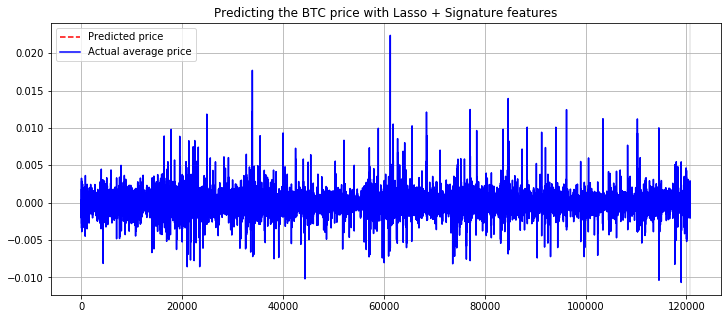

In [146]:
PlotResult(y_train, y_test, y_train_predict, y_test_predict, test_len, 'Lasso + Signature features')

# Elastic Net

In [120]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error


In [128]:
# sklearn.linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
param_search = {'alpha': [1e-5,1e-4,1e-3, 1e-2,1e-1,2e-1, 5e-1, 1], 'l1_ratio':[0.15,0.3,0.45,0.6,0.75,0.9]}
myModel = GridSearchCV(estimator=SGDClassifier(alpha = 0.1,
                                       
                                    
                                       max_iter = 10e5,
                                       penalty='elasticnet',
                                       loss='log'),
                        param_grid = param_search,
                        cv = TimeSeriesSplit(n_splits=8),
                        n_jobs=-1)

myModel.fit(X_train, y_train)

#Make predictions
y_train_predict = myModel.predict(X_train)
y_test_predict = myModel.predict(X_test)

In [129]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
print(cm)

[[279   0]
 [321   0]]


In [34]:
(256+795)/(196+753+256+795)

0.5255

# tests avec PCA etc. 

In [138]:
# prendre sur les heures pour meilleure estimation de Sigma 
pca=decomp.PCA(n_components=3)
pca.fit(X_scaled) 
X_pca=pca.transform(X_scaled)

In [139]:
ex_variance=np.var(X_pca, axis=0)

ex_variance_ratio = ex_variance/np.sum(ex_variance)
print (ex_variance_ratio)
# print(pca.components_)

[0.48291542 0.40589217 0.11119241]


C:\Users\Colomban Basset\Anaconda_v2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Colomban Basset\Anaconda_v2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


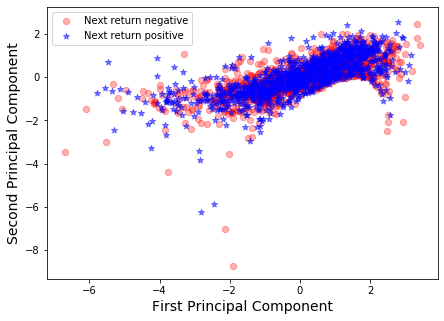

In [141]:
Xax=np.log(X_pca[:,0])
Yax=np.log(X_pca[:,2])
aa=len(BTC_price_time.index)
values=BTC_price_time['Sign_return']
labels=values[h_window+2:aa]
cdict={0:'red',1:'blue'}
labl={0:'Next return negative',1:'Next return positive'}
marker={0:'o',1:'*'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix=np.where(labels==l)
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.savefig('PCA_2.png')

# SVM

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
clf = SVC(kernel='poly', gamma=0.2, C=6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Random Forest

In [34]:
"""
param_search = {'alpha': [1e-5,1e-2,1e-1,2e-1, 5e-1, 1]}


myModel = GridSearchCV(estimator=Lasso(alpha = 0.1,
                                       normalize= True,
                                       max_iter = 10e5),
                        param_grid = param_search,
                        cv = TimeSeriesSplit(n_splits=5),
                        n_jobs=-1)
"""

"\nparam_search = {'alpha': [1e-5,1e-2,1e-1,2e-1, 5e-1, 1]}\n\n\nmyModel = GridSearchCV(estimator=Lasso(alpha = 0.1,\n                                       normalize= True,\n                                       max_iter = 10e5),\n                        param_grid = param_search,\n                        cv = TimeSeriesSplit(n_splits=5),\n                        n_jobs=-1)\n"

In [20]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

#mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Perform a GridsearchCV
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : [ 'l2'],
    'classifier__C' : np.logspace(-20, -4, 4, 20, 50),
    'classifier__solver' : ['newton-cg']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,150,160)),
    'classifier__max_features' : list(range(5,20, 40))}
]
pipe = Pipeline([('classifier' , RandomForestClassifier())])
myModel = GridSearchCV(pipe, param_grid = param_grid, cv = 8, verbose=True, n_jobs=-3)

# myModel.fit(X_scaled[:len(X_scaled)-240-1], values[h_window+1:aa-240])
myModel.fit(X_train, y_train)
#Make predictions
# y_train_predict = myModel.predict(X_scaled)
y_test_predict = myModel.predict(X_test)

#Calculate error
# error_train = mean_absolute_error(values[h_window:aa], y_train_predict)        
# error_test = mean_absolute_error(y_test, y_test_predict)
# p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
# p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

# print('mae_train:{0:.3f} = {1:.3f}%\n'.format(error_train, p_error_train))
# print('mae_test:{0:.3f} = {1:.3f}%'.format(error_test, p_error_test))



Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 out of  40 | elapsed:    4.8s finished


In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
print(cm)

[[143 136]
 [153 168]]


In [51]:
114/(200)

0.57

In [212]:
print(myModel.best_estimator_.feature_importances_)

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [277]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = myModel.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = myModel.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

AttributeError: 'GridSearchCV' object has no attribute 'estimators'

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [253]:
Y_test_l=[]
for i in Y_test_list:
    Y_test_l.append(i)

In [254]:
Y_test_list=y_test
j=0
ok=0
tot=0
for i in y_test_predict:
#     print(i, Y_test_list[j])
    if i==Y_test_l[j]:
        ok+=1
    tot+=1
    j+=1
print("ok",ok)
print("tot",tot)



ok 24225
tot 34995


# Neural networks sans Keras

In [185]:
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],15) 
        self.weights2   = np.random.rand(15,1)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
        
    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2
        
if __name__ == "__main__":
    nn = NeuralNetwork(X_train,y_train)

    for i in range(1500):
        nn.feedforward()
        nn.backprop()

    print(nn.output)

[[0.5       ]
 [0.5       ]
 [0.5       ]
 ...
 [0.5       ]
 [0.49999997]
 [0.5       ]]


In [193]:
print(nn.weights1)

[[ 4.13722374e-01  5.21077716e-01  5.31520856e-01  7.45755045e-01
   7.08998644e-01  7.78987556e-01  1.12806371e-01  8.85135327e-01
   2.05626921e-01  1.29360844e-01  4.57144373e-01  8.75954797e-01
   5.47417305e-01  9.79684716e-01  1.11063341e-01]
 [ 3.62339997e+01  3.30553155e+01  3.62204409e+01  4.19391799e+01
   5.35018525e+01  3.82940448e+01  6.85403202e+01  4.47298872e+01
   4.23453855e+01  4.03948800e+01  4.68450036e+01  4.34622321e+01
   4.14306897e+01  5.30637058e+01  3.71179664e+01]
 [ 4.02205797e-02 -8.70337129e-01  1.03241599e+00 -8.38165153e-01
  -7.25565513e-01 -1.50068164e-01  7.74161207e-01 -3.31562118e-01
  -6.17341531e-01 -5.44439330e-01  6.69942802e-01 -9.17173503e-01
  -5.46696013e-01 -8.69560244e-02  6.91465946e-03]
 [ 2.22244589e-01 -3.72184490e-01  4.02225416e-01 -7.64475858e-01
  -1.31847754e+00 -2.26794611e-01  8.08702826e-01 -7.72412920e-01
  -9.92143062e-01  2.25336587e-01  1.55350815e+00 -1.05812736e+00
  -5.99397740e-01  2.47517745e-01  3.74980617e-01]
 [ 1

In [187]:
up=0
down=0
inte=0
for i in nn.output:
    if i>0.5:
        up+=1
    elif i <0.5:
        down+=1
    else:
        inte+=1

print(inte, up, down)

470 0 6727


### XGBOOST

In [22]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#GridsearchCV    
param_search = {
    'max_depth':[4,5,6]
    ,'min_child_weight':[4,5,6]
    ,'gamma':[i/10.0 for i in range(0,5)]
}

myModel = GridSearchCV(estimator=XGBRegressor(
                        objective='binary:logistic',
                        learning_rate=0.01,
                        n_estimators=500,
                        max_depth=5,
                        min_child_weight=5,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8, 
                        eval_metric ='mae',
                        reg_alpha=0.05
                        ),
                       param_grid = param_search,
                       cv = TimeSeriesSplit(n_splits=4),n_jobs=-1
                      )

#Fit model
myModel.fit(X_train, y_train)

#Make predictions
# y_train_predict = myModel.predict(X_train)
y_test_predict = myModel.predict(X_test)



In [204]:
y_test.iloc[0]

Sign_return    0
Name: 32683, dtype: int32

In [24]:
positif=0
negatif=0
extreme=0
inter=0
i=0
hg,hd,bg,bd=0
while i < len(y_test_predict):
    if y_test_predict[i]>0.5:
        if np.asscalar(y_test.iloc[i])>0.5:
            hg+=1
            extreme+=1
        else:
            hd+=1
            extreme+=1
    elif y_test_predict[i]<0.5:
        if np.asscalar(y_test.iloc[i])<0.5:
            bd+=1
        else:
            bg+=1
    else:
        inter+=1
    i+=1
            
print('[',hg,hd)
print(' ', bg,bd,']')

[ 177 168
  144 111 ]


In [25]:
X_sig

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.000259,-0.016236,-0.016236,3.366252e-08,-2.164571e-06,-3.217765e-06,-2.048202e-06,1.318043e-04,0.000198,...,-1.325203e-06,-6.454388e-11,4.261871e-09,8.523742e-09,4.261871e-09,-2.814139e-07,-5.628278e-07,3.815621e-09,-2.519478e-07,-7.133260e-07
2,1.0,0.000259,-0.003234,-0.003234,3.366252e-08,4.819740e-07,2.721727e-07,-1.321179e-06,5.230340e-06,0.000056,...,3.099799e-08,-7.209250e-11,-2.963047e-09,-5.926095e-09,-2.963047e-09,-1.217831e-07,-2.435663e-07,4.760311e-09,1.956518e-07,-5.638824e-09
3,1.0,0.000259,0.020557,0.020557,3.366252e-08,3.308775e-06,4.642291e-06,2.025292e-06,2.113053e-04,0.000341,...,2.891405e-06,4.487386e-11,5.266240e-09,1.053248e-08,5.266240e-09,6.180276e-07,1.236055e-06,1.844344e-09,2.164458e-07,1.447969e-06
4,1.0,0.000259,-0.002180,-0.002180,3.366252e-08,-2.399488e-06,-2.540899e-06,1.833848e-06,2.376154e-06,0.000270,...,-2.600227e-06,1.281304e-10,-1.718995e-08,-3.437989e-08,-1.718995e-08,2.306200e-06,4.612400e-06,1.503694e-08,-2.017352e-06,-1.726656e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1.0,0.000259,-0.000824,-0.000824,3.366252e-08,-9.501148e-07,-1.003575e-06,7.362736e-07,3.396066e-07,0.000043,...,-1.630036e-07,5.122820e-11,-2.729089e-09,-5.458178e-09,-2.729089e-09,1.453872e-07,2.907744e-07,2.403662e-09,-1.280507e-07,-9.329491e-11
7703,1.0,0.000259,-0.008183,-0.008183,3.366252e-08,-6.957458e-07,-1.226546e-06,-1.427455e-06,3.347923e-05,0.000058,...,-2.324163e-07,-5.816389e-11,5.700039e-10,1.140008e-09,5.700039e-10,-5.586015e-09,-1.117203e-08,3.098575e-09,-3.036591e-08,-9.131810e-08
7704,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7705,1.0,0.000259,NaN,NaN,3.366252e-08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
print(myModel.best_estimator_.feature_importances_)

[0.         0.02217964 0.02438003 0.02313352 0.02394369 0.04952685
 0.03309746 0.026176   0.02358847 0.02578573 0.02823449 0.02392865
 0.02444016 0.01942685 0.04711006 0.04248358 0.01905739 0.02398582
 0.02707545 0.0223048  0.02479846 0.02605391 0.02769689 0.0263687
 0.02536069 0.02417295 0.0208504  0.02604489 0.02520593 0.02479281
 0.0294388  0.03295272 0.0291963  0.         0.         0.02515981
 0.0270554  0.02445789 0.0263692  0.02416557]


In [ ]:
liste=[]

for i in data_final.columns.values:
    liste.append(i)
liste.remove('opp_id')
liste.remove('target')
print(liste)

In [ ]:
i=0
while i<len(liste):
    print(xgb_reg.feature_importances_[i],liste[i])
    i+=1

# Neural network

In [99]:
from keras.models import Sequential
from keras.layers import Dense
# X = pd.DataFrame(X_scaled)
# y = pd.DataFrame(values[h_window+1:len(values)])
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Using TensorFlow backend.


In [100]:
X_train.shape[1]

40

In [101]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal', input_dim=40))
#Second  Hidden Layer
# classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(5, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [102]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [103]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10, epochs=100)

Epoch 1/100
1074/1074 [==============================] - 0s 341us/step - loss: 0.6931 - accuracy: 0.5140
Epoch 2/100
1074/1074 [==============================] - 0s 150us/step - loss: 0.6912 - accuracy: 0.5121
Epoch 3/100
1074/1074 [==============================] - 0s 147us/step - loss: 0.6892 - accuracy: 0.5363
Epoch 4/100
1074/1074 [==============================] - 0s 146us/step - loss: 0.6887 - accuracy: 0.5307
Epoch 5/100
1074/1074 [==============================] - 0s 155us/step - loss: 0.6871 - accuracy: 0.5363
Epoch 6/100
1074/1074 [==============================] - 0s 161us/step - loss: 0.6861 - accuracy: 0.5493
Epoch 7/100
1074/1074 [==============================] - 0s 145us/step - loss: 0.6858 - accuracy: 0.5559
Epoch 8/100
1074/1074 [==============================] - 0s 141us/step - loss: 0.6856 - accuracy: 0.5391
Epoch 9/100
1074/1074 [==============================] - 0s 148us/step - loss: 0.6844 - accuracy: 0.5521
Epoch 10/100
1074/1074 [==============================]

In [105]:
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

In [106]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24 62]
 [33 81]]


In [79]:
(557+512)/2000

0.5345

# Recurrent neural network

In [120]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [149]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [173]:
model = Sequential()
model.add(LSTM(32, return_sequences=True))
model.add(Dense(10, activation='softmax'))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train,y_train, epochs=200, batch_size=7988, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
y_pred=model.predict(X_test)

Train on 7988 samples, validate on 1999 samples
Epoch 1/200
7988/7988 [==============================] - 1s 129us/step - loss: 0.7017 - val_loss: 0.6636
Epoch 2/200
7988/7988 [==============================] - 0s 19us/step - loss: 0.6902 - val_loss: 0.6520
Epoch 3/200
7988/7988 [==============================] - 0s 18us/step - loss: 0.6787 - val_loss: 0.6404
Epoch 4/200
7988/7988 [==============================] - 0s 16us/step - loss: 0.6674 - val_loss: 0.6288
Epoch 5/200
7988/7988 [==============================] - 0s 15us/step - loss: 0.6560 - val_loss: 0.6172
Epoch 6/200
7988/7988 [==============================] - 0s 16us/step - loss: 0.6446 - val_loss: 0.6056
Epoch 7/200
7988/7988 [==============================] - 0s 15us/step - loss: 0.6332 - val_loss: 0.5939
Epoch 8/200
7988/7988 [==============================] - 0s 18us/step - loss: 0.6217 - val_loss: 0.5822
Epoch 9/200
7988/7988 [==============================] - 0s 18us/step - loss: 0.6103 - val_loss: 0.5704
Epoch 10/200
79

In [174]:
y_pred

array([[[0.53678143]],

       [[0.5206697 ]],

       [[0.44276112]],

       ...,

       [[0.43094617]],

       [[0.45915782]],

       [[0.516367  ]]], dtype=float32)

In [176]:
j=0
hg=0
hd=0
bg=0
bd=0
for i in y_pred:
    if (i >0.5 and y_test[j]==1):
        bd +=1
    elif (i <0.5 and y_test[j]==0):
        hg+=1
    elif(i<0.5 and y_test[j]==1):
        bg+=1
    else:
        hd+=1
    j+=1
print(hg,bg,hd,bd)
        

516 447 492 544


In [179]:
print((hg+bd+1)/2000)

0.5305
